In [1]:
from sklearn.model_selection import train_test_split
import pandas as pd

df = pd.read_csv('data/processed.csv', index_col=0)
y = df.pop('co2')
X = df.copy(deep=True)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [2]:
X.describe()

,num_employees,income,energy_usage
count,10000.000000,1.000000e+04,10000.000000
mean,10493.395900,5.160171e+08,50959.400000
std,2696.658346,1.281942e+08,12480.998725
min,1.000000,1.200000e+04,5000.000000
25%,8696.000000,4.298262e+08,43000.000000
50%,10483.500000,5.169610e+08,51000.000000
75%,12310.000000,6.044595e+08,59000.000000
max,20000.000000,1.000012e+09,105000.000000


In [3]:
from sklearn.ensemble import RandomForestRegressor
from lightgbm import LGBMRegressor
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeRegressor
from skopt import BayesSearchCV
from skopt.space import Categorical, Integer, Real

import warnings

warnings.filterwarnings('ignore', message='The objective has been evaluated at this point before.')

pipe = Pipeline(steps=[("scaler", StandardScaler()), ("clf", LinearRegression())])
lr_search = {
    "clf": [LinearRegression()]
}
dt_search = {
    "clf": [DecisionTreeRegressor()],
    #     "clf__criterion": Categorical(["gini", "entropy"]),
    "clf__max_depth": Integer(2, 20),
    "clf__min_samples_leaf": Integer(2, 50),
}
rf_search = {
    "clf": [RandomForestRegressor()],
    #         "clf__criterion": Categorical(["squared_error", "gini"]),
    "clf__max_depth": Integer(2, 20),
    "clf__min_samples_leaf": Integer(2, 50),
},
lgbm_search = {

    "clf": [LGBMRegressor(objective='regression', metric='rmse', boosting_type='gbdt')],
    # "clf__num_leaves": Integer(1, 15),
    'clf__reg_sqrt': Categorical([True, False]),
    "clf__n_estimators": Integer(25, 3000),
    #     "clf__boosting_type": Categorical(["gbdt"]),
    'clf__learning_rate': Real(0.01, 0.5, prior='log-uniform'),
    'clf__max_depth': Integer(-1, 128),
    'clf__num_leaves': Integer(2, 512),
    #     'clf__feature_fraction': Real(0.1, 1.0, prior='uniform'),
    'clf__subsample': Real(0.1, 1.0, prior='uniform'),
    'clf__colsample_bytree': Real(0.01, 1.0, 'uniform'),  # Subsample ratio of columns when constructing each tree
    'clf__reg_lambda': Real(1e-9, 100.0, 'log-uniform'),  # L2 regularization
    'clf__reg_alpha': Real(1e-9, 100.0, 'log-uniform'),  # L1 regularization
}

opt = BayesSearchCV(pipe,
                    [
                        # (lgbm_search, 20),
                        # (lr_search, 1),
                        (dt_search, 20)
                    ],
                    cv=3,
                    scoring='r2',
                    verbose=0,
                    return_train_score=True,
                    n_jobs=-1
                    )

opt.fit(X_train, y_train)
!say done

In [4]:
columns = ['params', 'mean_test_score', 'mean_train_score', 'mean_fit_time', 'std_test_score']
cv_df = pd.DataFrame(opt.cv_results_).sort_values(by='rank_test_score')[columns].reset_index(drop=True)
cv_df = cv_df.join(cv_df.pop('params').apply(pd.Series))
cv_df.clf = cv_df.clf.apply(lambda x: x.__str__().split('(')[0].replace('Classifier', '')).astype("category")
cv_df.head(10)

,mean_test_score,mean_train_score,mean_fit_time,std_test_score,clf,clf__max_depth,clf__min_samples_leaf
0,0.695469,0.727752,0.011128,0.005904,DecisionTreeRegressor,17,50
1,0.695469,0.727752,0.009276,0.005904,DecisionTreeRegressor,10,50
2,0.695469,0.727752,0.014342,0.005904,DecisionTreeRegressor,20,50
3,0.695469,0.727752,0.013559,0.005904,DecisionTreeRegressor,11,50
4,0.694870,0.726564,0.010518,0.005004,DecisionTreeRegressor,7,50
5,0.694311,0.729199,0.009587,0.005584,DecisionTreeRegressor,20,48
6,0.689312,0.727511,0.005597,0.009783,DecisionTreeRegressor,6,29
7,0.688482,0.742068,0.006531,0.011665,DecisionTreeRegressor,8,27
8,0.687760,0.736667,0.008233,0.010181,DecisionTreeRegressor,20,37
9,0.686637,0.739933,0.006864,0.010823,DecisionTreeRegressor,14,33


In [5]:
import matplotlib.pyplot as plt

# print(plt.style.available)
plt.style.use('seaborn-v0_8-paper');

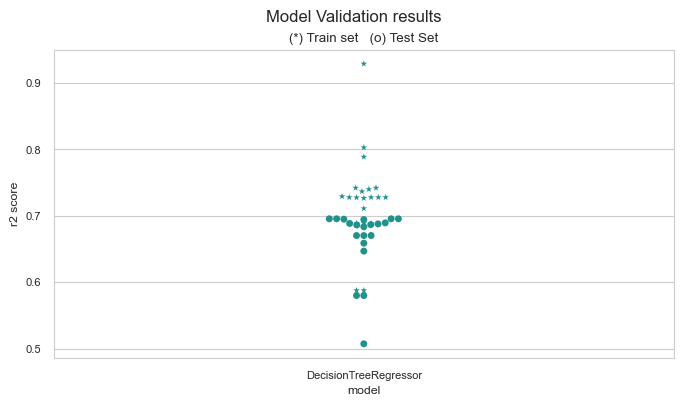

In [6]:
import seaborn as sns
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(8, 4), dpi=100)
sns.swarmplot(x="clf", y="mean_test_score", data=cv_df, palette='viridis', hue='clf', ax=ax)
sns.swarmplot(x="clf", y="mean_train_score", data=cv_df, palette='viridis', hue='clf', marker='*', ax=ax)
plt.xlabel('model')
plt.ylabel('r2 score')
plt.suptitle('Model Validation results')
plt.title('(*) Train set   (o) Test Set');
ax.get_legend().remove()


In [7]:
opt.best_estimator_

Pipeline(steps=[('scaler', StandardScaler()),
                ('clf',
                 DecisionTreeRegressor(max_depth=20, min_samples_leaf=50))])

In [22]:
model_arch = DecisionTreeRegressor(max_depth=20, min_samples_split=50)
pipe = Pipeline(steps=[("scaler", StandardScaler()), ("clf", model_arch)])
pipe.fit(X, y)

Pipeline(steps=[('scaler', StandardScaler()),
                ('clf',
                 DecisionTreeRegressor(max_depth=20, min_samples_split=50))])

In [23]:
pipe.score(X, y)

0.7852184597262063

# Save Model

In [24]:
import joblib

joblib.dump(pipe, 'model/best_model.pkl');

# Feature Importance

In [25]:
import shap

model = pipe.steps[-1][-1]
preprocessing = pipe.steps[0][-1]
X_transformed = preprocessing.transform(X_test)

explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_transformed)

In [26]:
feature_names = X.columns

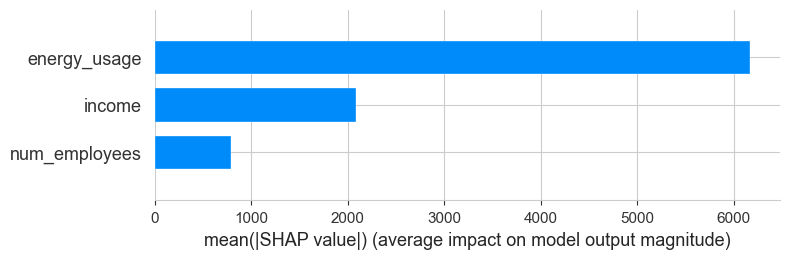

In [27]:
shap.summary_plot(shap_values, X_train, feature_names=feature_names, plot_type="bar")

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


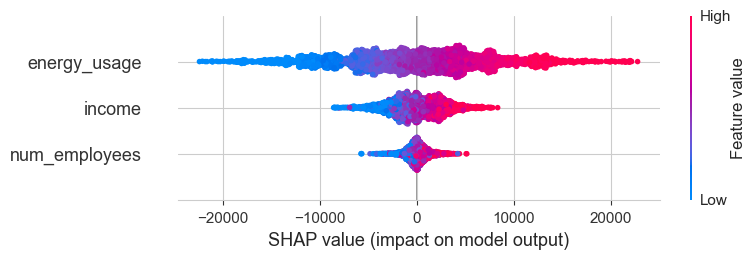

In [28]:
shap.summary_plot(shap_values, X_transformed, feature_names=feature_names)

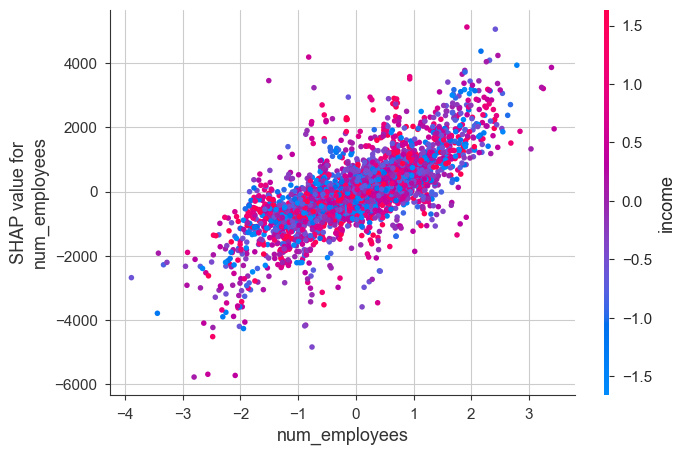

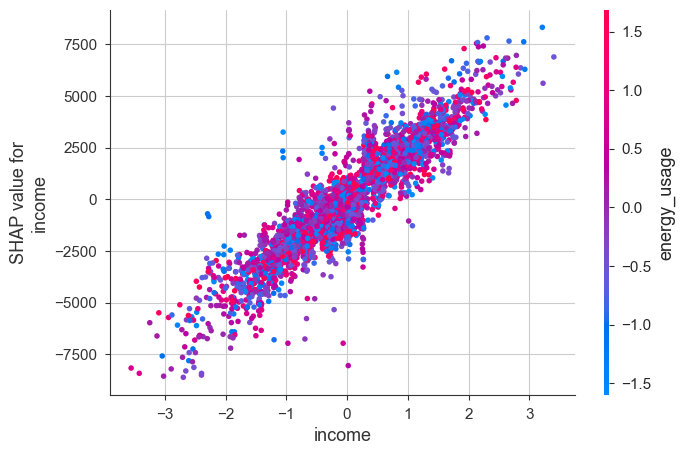

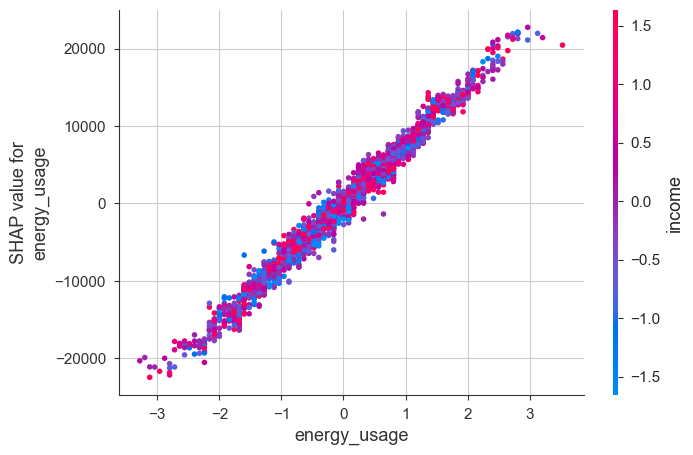

In [29]:
for i in range(len(feature_names)):
    shap.dependence_plot(i, shap_values, X_transformed, feature_names=feature_names)

In [34]:
X_test.iloc[18]

num_employees         9195
income           522715000
energy_usage         60000
Name: 7051, dtype: int64

In [44]:
X_test.iloc[0]

num_employees         9470
income           586223000
energy_usage         54000
Name: 6252, dtype: int64

In [61]:
input_data = pd.DataFrame([{
    'num_employees': 100_000,
    'income': 400_000_000,
    'energy_usage': 46_000
}])


TypeError: 'numpy.ndarray' object is not callable

In [99]:
show_values = {}
show_values['num_employees'] = '{:,}'.format(input_data['num_employees'][0])
show_values['income'] = '${:,}'.format(input_data['income'][0])
show_values['energy_usage'] = '{:,}kWh'.format(input_data['energy_usage'][0])
show_values = pd.DataFrame([show_values])

In [100]:
show_values

,num_employees,income,energy_usage
0,"100,000","$400,000,000","46,000kWh"


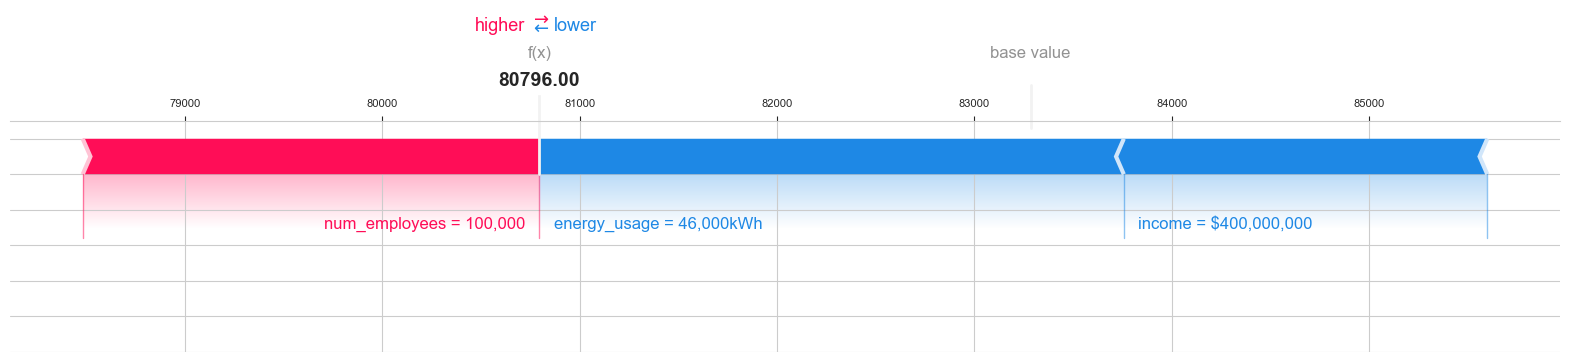

In [101]:
shap.initjs()
input_data = pd.DataFrame([{
    'num_employees': 100_000,
    'income': 400_000_000,
    'energy_usage': 46_000
}])
input_data_transformed = preprocessing.transform(input_data)
input_shap_values = explainer.shap_values(input_data_transformed)

shap.force_plot(explainer.expected_value, input_shap_values[0], show_values, feature_names = feature_names, matplotlib=True)

In [17]:
plt.style.available

['Solarize_Light2',
 '_classic_test_patch',
 '_mpl-gallery',
 '_mpl-gallery-nogrid',
 'bmh',
 'classic',
 'dark_background',
 'fast',
 'fivethirtyeight',
 'ggplot',
 'grayscale',
 'seaborn-v0_8',
 'seaborn-v0_8-bright',
 'seaborn-v0_8-colorblind',
 'seaborn-v0_8-dark',
 'seaborn-v0_8-dark-palette',
 'seaborn-v0_8-darkgrid',
 'seaborn-v0_8-deep',
 'seaborn-v0_8-muted',
 'seaborn-v0_8-notebook',
 'seaborn-v0_8-paper',
 'seaborn-v0_8-pastel',
 'seaborn-v0_8-poster',
 'seaborn-v0_8-talk',
 'seaborn-v0_8-ticks',
 'seaborn-v0_8-white',
 'seaborn-v0_8-whitegrid',
 'tableau-colorblind10']

In [18]:
df = pd.read_csv('https://raw.githubusercontent.com/owid/co2-data/master/owid-co2-data.csv')

In [19]:
df = df[['country', 'year', 'iso_code', 'population', 'gdp', 'energy_per_capita', 'co2']]

In [20]:
from ydata_profiling import ProfileReport

profile = ProfileReport(df, title="Profiling Report")

In [21]:
profile.to_file("your_report.html")

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]